In [1]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Kern County Polygon Analysis

# Data Preparation

In [1]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import contextily as cx
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [14]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}

Polygon analysis is conducted on a set of worst performing fields based on Mean Absolute Error. This analysis is conducted to see if polygon forecasting is more accurate than point forecasting.

### Historical Import

In [3]:
poly_historical = pd.read_csv('../data/kern_polygon_large_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158400 entries, 0 to 158399
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   field_id     158400 non-null  object        
 1   crop         158400 non-null  int64         
 2   time         158400 non-null  datetime64[ns]
 3   actual_et    158400 non-null  float64       
 4   actual_eto   158400 non-null  float64       
 5   actual_etof  158400 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.3+ MB


In [17]:
poly_fields = poly_historical['field_id'].unique()

### Forecast Table

In [5]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/0.0.1/polygon/kern/sampled/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640500 entries, 0 to 640499
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          640500 non-null  object        
 1   crop              640500 non-null  int64         
 2   time              640500 non-null  datetime64[ns]
 3   expected_et       640500 non-null  float64       
 4   expected_eto      640500 non-null  float64       
 5   expected_etof     640500 non-null  float64       
 6   forecasting_date  640500 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 34.2+ MB


### Main Table Compilation

In [6]:
poly_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
poly_dt = poly_dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
poly_dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-08-05,CA_298397,75,2024-01-01,0.237,1.010,0.235,0.237,1.010,0.235
1,2024-08-05,CA_298397,75,2024-01-02,0.111,0.459,0.241,0.111,0.459,0.241
2,2024-08-05,CA_298397,75,2024-01-03,0.295,1.193,0.247,0.295,1.193,0.247
3,2024-08-05,CA_298397,75,2024-01-04,0.535,2.111,0.254,0.535,2.111,0.254
4,2024-08-05,CA_298397,75,2024-01-05,0.358,1.377,0.260,0.358,1.377,0.260
...,...,...,...,...,...,...,...,...,...,...
640495,2024-01-29,CA_298397,75,2024-12-27,NaN,NaN,NaN,0.297,1.056,0.281
640496,2024-01-29,CA_298397,75,2024-12-28,NaN,NaN,NaN,0.305,1.078,0.284
640497,2024-01-29,CA_298397,75,2024-12-29,NaN,NaN,NaN,0.304,1.067,0.286
640498,2024-01-29,CA_298397,75,2024-12-30,NaN,NaN,NaN,0.289,1.008,0.288


### Reference Tables

### Add USDA crop data

In [24]:
# Add crop data
cdl_codes = pd.read_csv("../data/cdl_codes.csv", low_memory=False).set_index("Codes")

#### Average ET/ETo/ETof for 2024

In [7]:
poly_avgs = poly_dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_avgs.head()

,,actual_et,actual_eto,actual_etof
field_id,crop,,,
CA_298397,75,1.824976,5.319606,0.425980
CA_299395,75,4.438549,4.946793,0.880626
CA_299467,75,3.671130,4.955939,0.792061
CA_300271,75,1.914671,5.162028,0.392902
CA_300581,75,3.964707,5.091098,0.762366


#### Climatology Reference

In [8]:
# Create a column for day of year
poly_historical['doy'] = poly_historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
poly_climatology = poly_historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
poly_climatology

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_298397 75   1     0.284889    1.030000     0.294111
               2     0.333222    1.142111     0.299889
               3     0.377222    1.254333     0.305556
               4     0.422444    1.356333     0.311667
               5     0.355333    1.193111     0.321333
...                       ...         ...          ...
CA_42143  69   362   0.542625    0.928250     0.600875
               363   0.566625    0.928250     0.607875
               364   0.549750    0.893000     0.614625
               365   0.446000    0.716750     0.618750
               366   0.401500    0.658000     0.650500

[18300 rows x 3 columns]

### Accuracy Metric Calculation

In [9]:
analysis_end_date = poly_historical['time'].max()

In [10]:
# poly_metrics = (poly_dt[(poly_dt['time'] > poly_dt['forecasting_date']) & (poly_dt['time'] < (poly_dt['forecasting_date']) + timedelta(days=7)) & (poly_dt['time'] < analysis_end_date)]
#                 .groupby(['forecasting_date'])[list(poly_dt.columns)]
#                 .apply(eval_metrics, normalize=True, climatology_ref=poly_climatology, avgs_ref=poly_avgs))
# poly_metrics.reset_index().to_csv('data/metrics/kern_poly_metrics.csv', index=False)

In [12]:
poly_metrics = pd.read_csv('../data/metrics/kern_poly_metrics.csv').drop(['level_1'], axis=1)
poly_metrics['forecasting_date'] = pd.to_datetime(poly_metrics['forecasting_date'])

### Visualization

In [20]:
# First reshape data from wide-form to long-form
poly_metrics_long = poly_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
poly_metrics_long['name'] = poly_metrics_long['stat'].map(stat_propers)

#### Interquartile Metrics

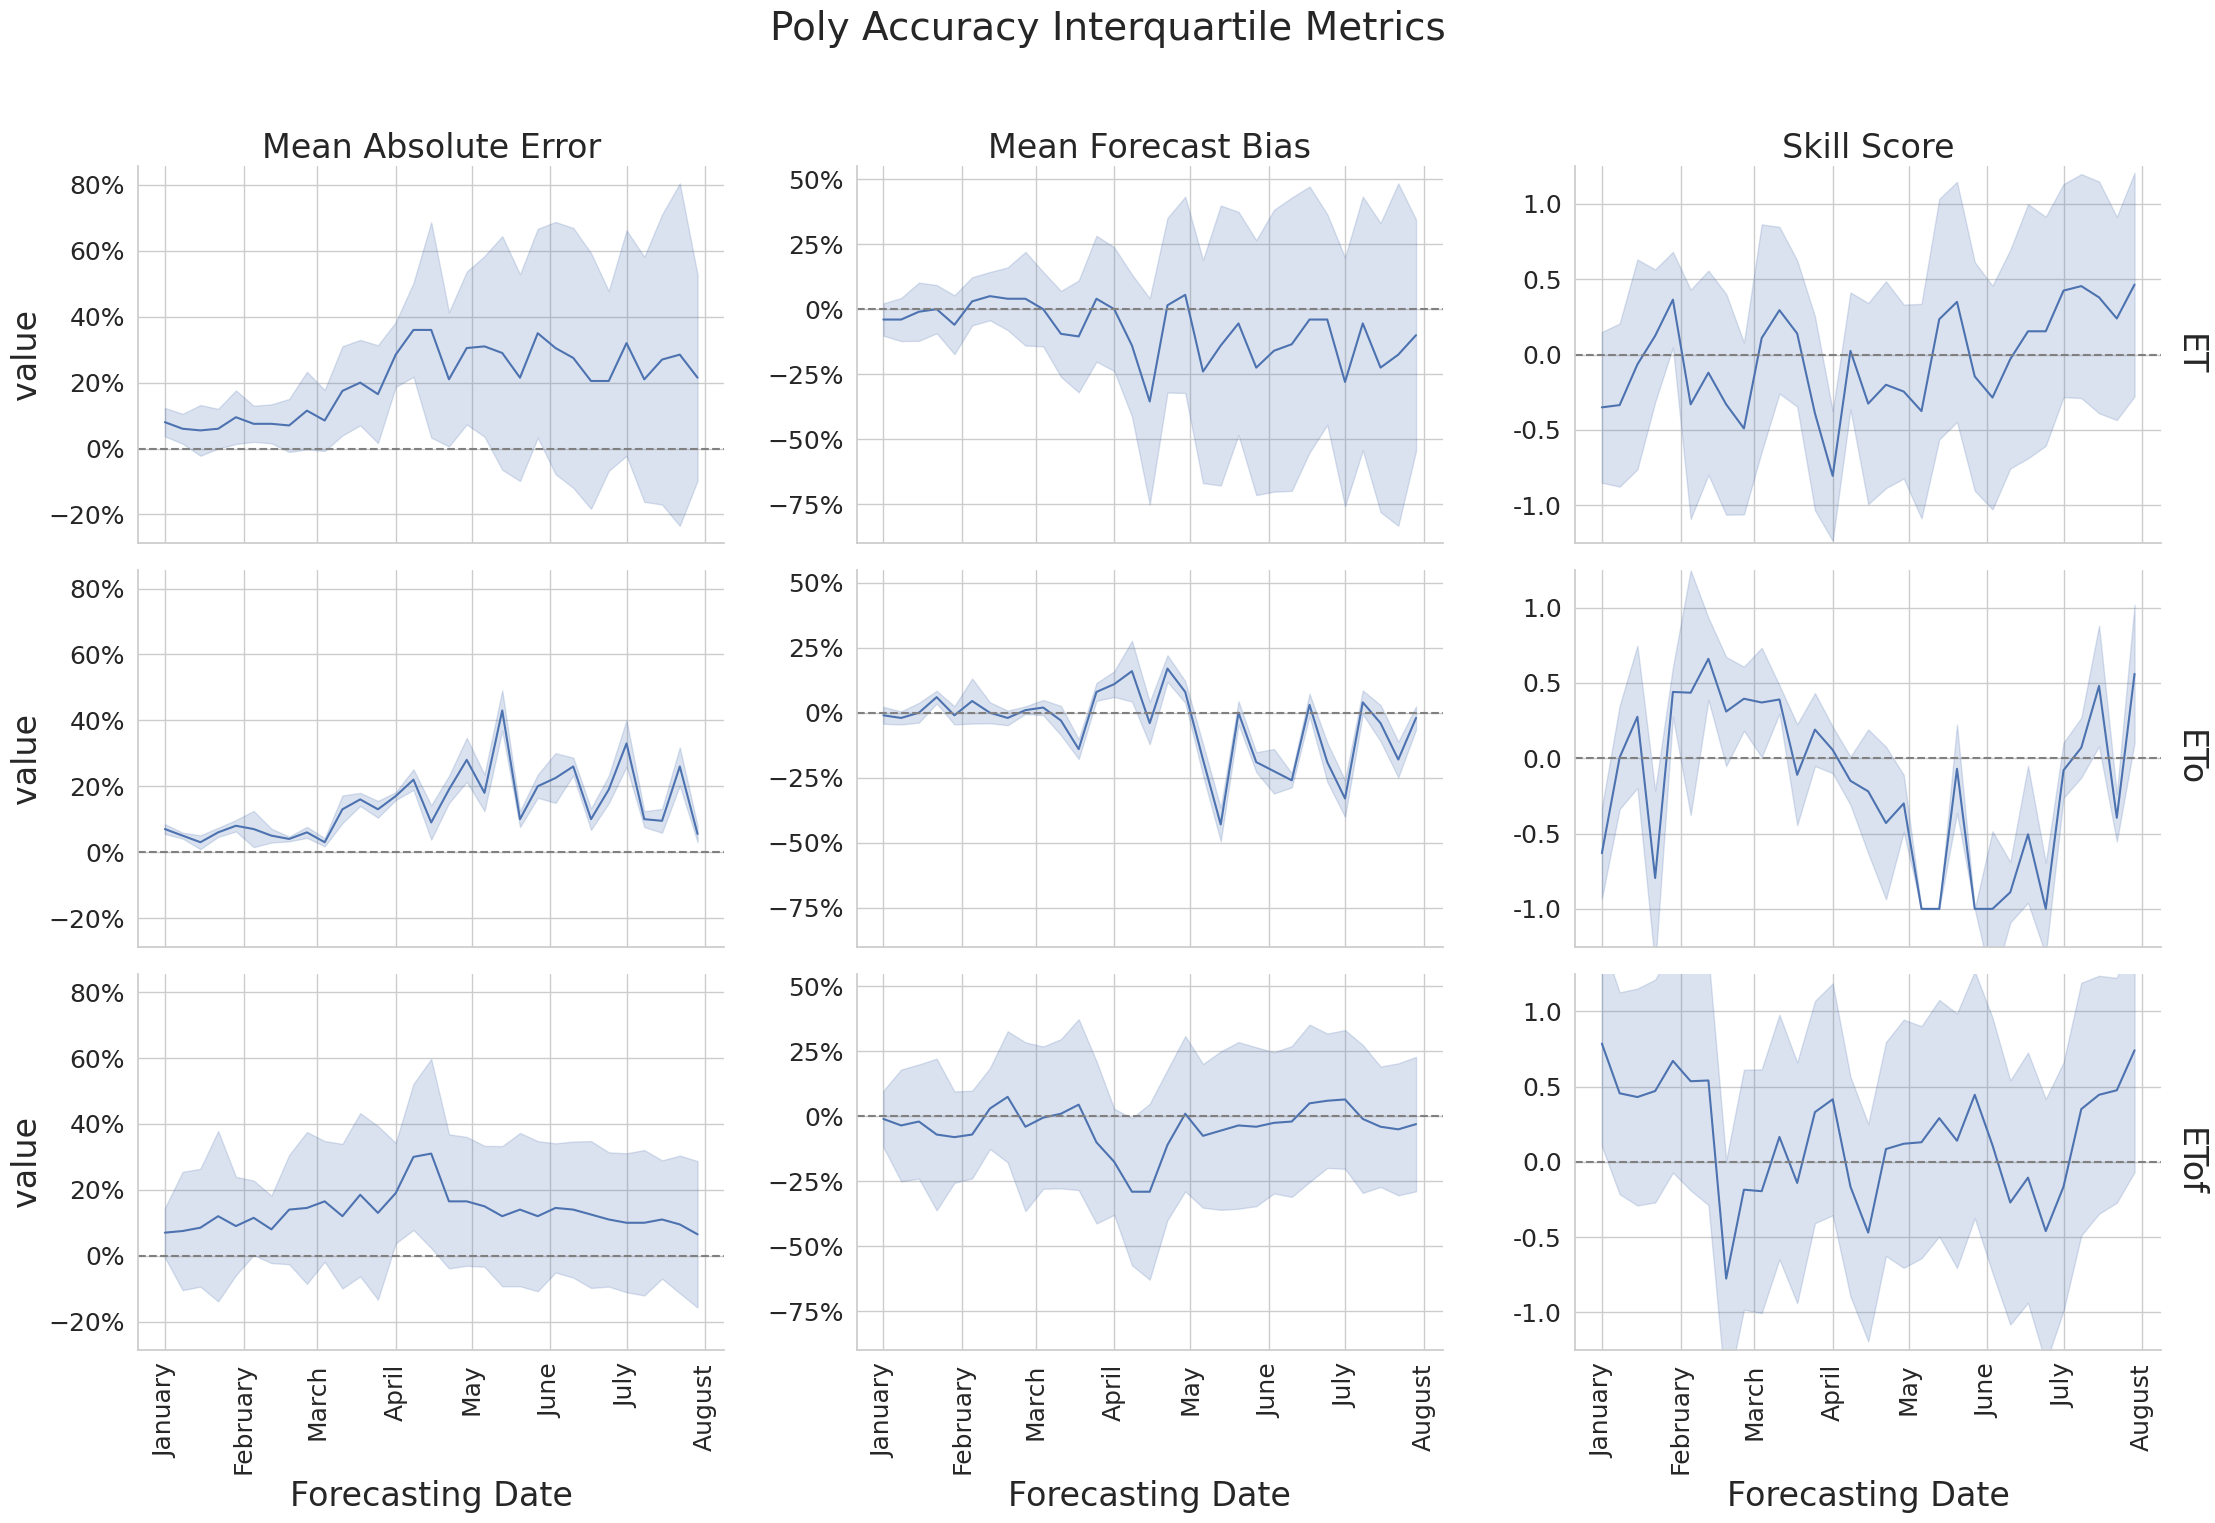

In [22]:
rel = timeseries_rel(poly_metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Poly Accuracy Interquartile Metrics");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/poly_field_metric_range_sd.png')

#### Point vs Polygon Comparison

A comparison is made against the same fields specified by the Polygon table.

In [15]:
point_metrics = pd.read_csv('../data/metrics/kern_metrics_normalized.csv', low_memory=False).drop(columns='level_1')
point_metrics['forecasting_date'] = pd.to_datetime(point_metrics['forecasting_date'])
point_metrics_long = point_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

point_metrics_long['name'] = point_metrics_long['stat'].map(stat_propers)
point_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342090 entries, 0 to 342089
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  342090 non-null  datetime64[ns]
 1   field_id          342090 non-null  object        
 2   crop              342090 non-null  int64         
 3   variable          342090 non-null  object        
 4   stat              342090 non-null  object        
 5   value             342090 non-null  float64       
 6   name              342090 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 18.3+ MB


In [18]:
point_cmp_metrics = point_metrics_long[point_metrics_long['field_id'].isin(poly_fields)]

In [25]:
point_cmp_metrics.loc[:, 'shape'] = 'point'
poly_metrics_long['shape'] = 'polygon'

shape_metrics_long = pd.concat([point_cmp_metrics, poly_metrics_long])
shape_metrics_long = shape_metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

##### Interquartile Comparison

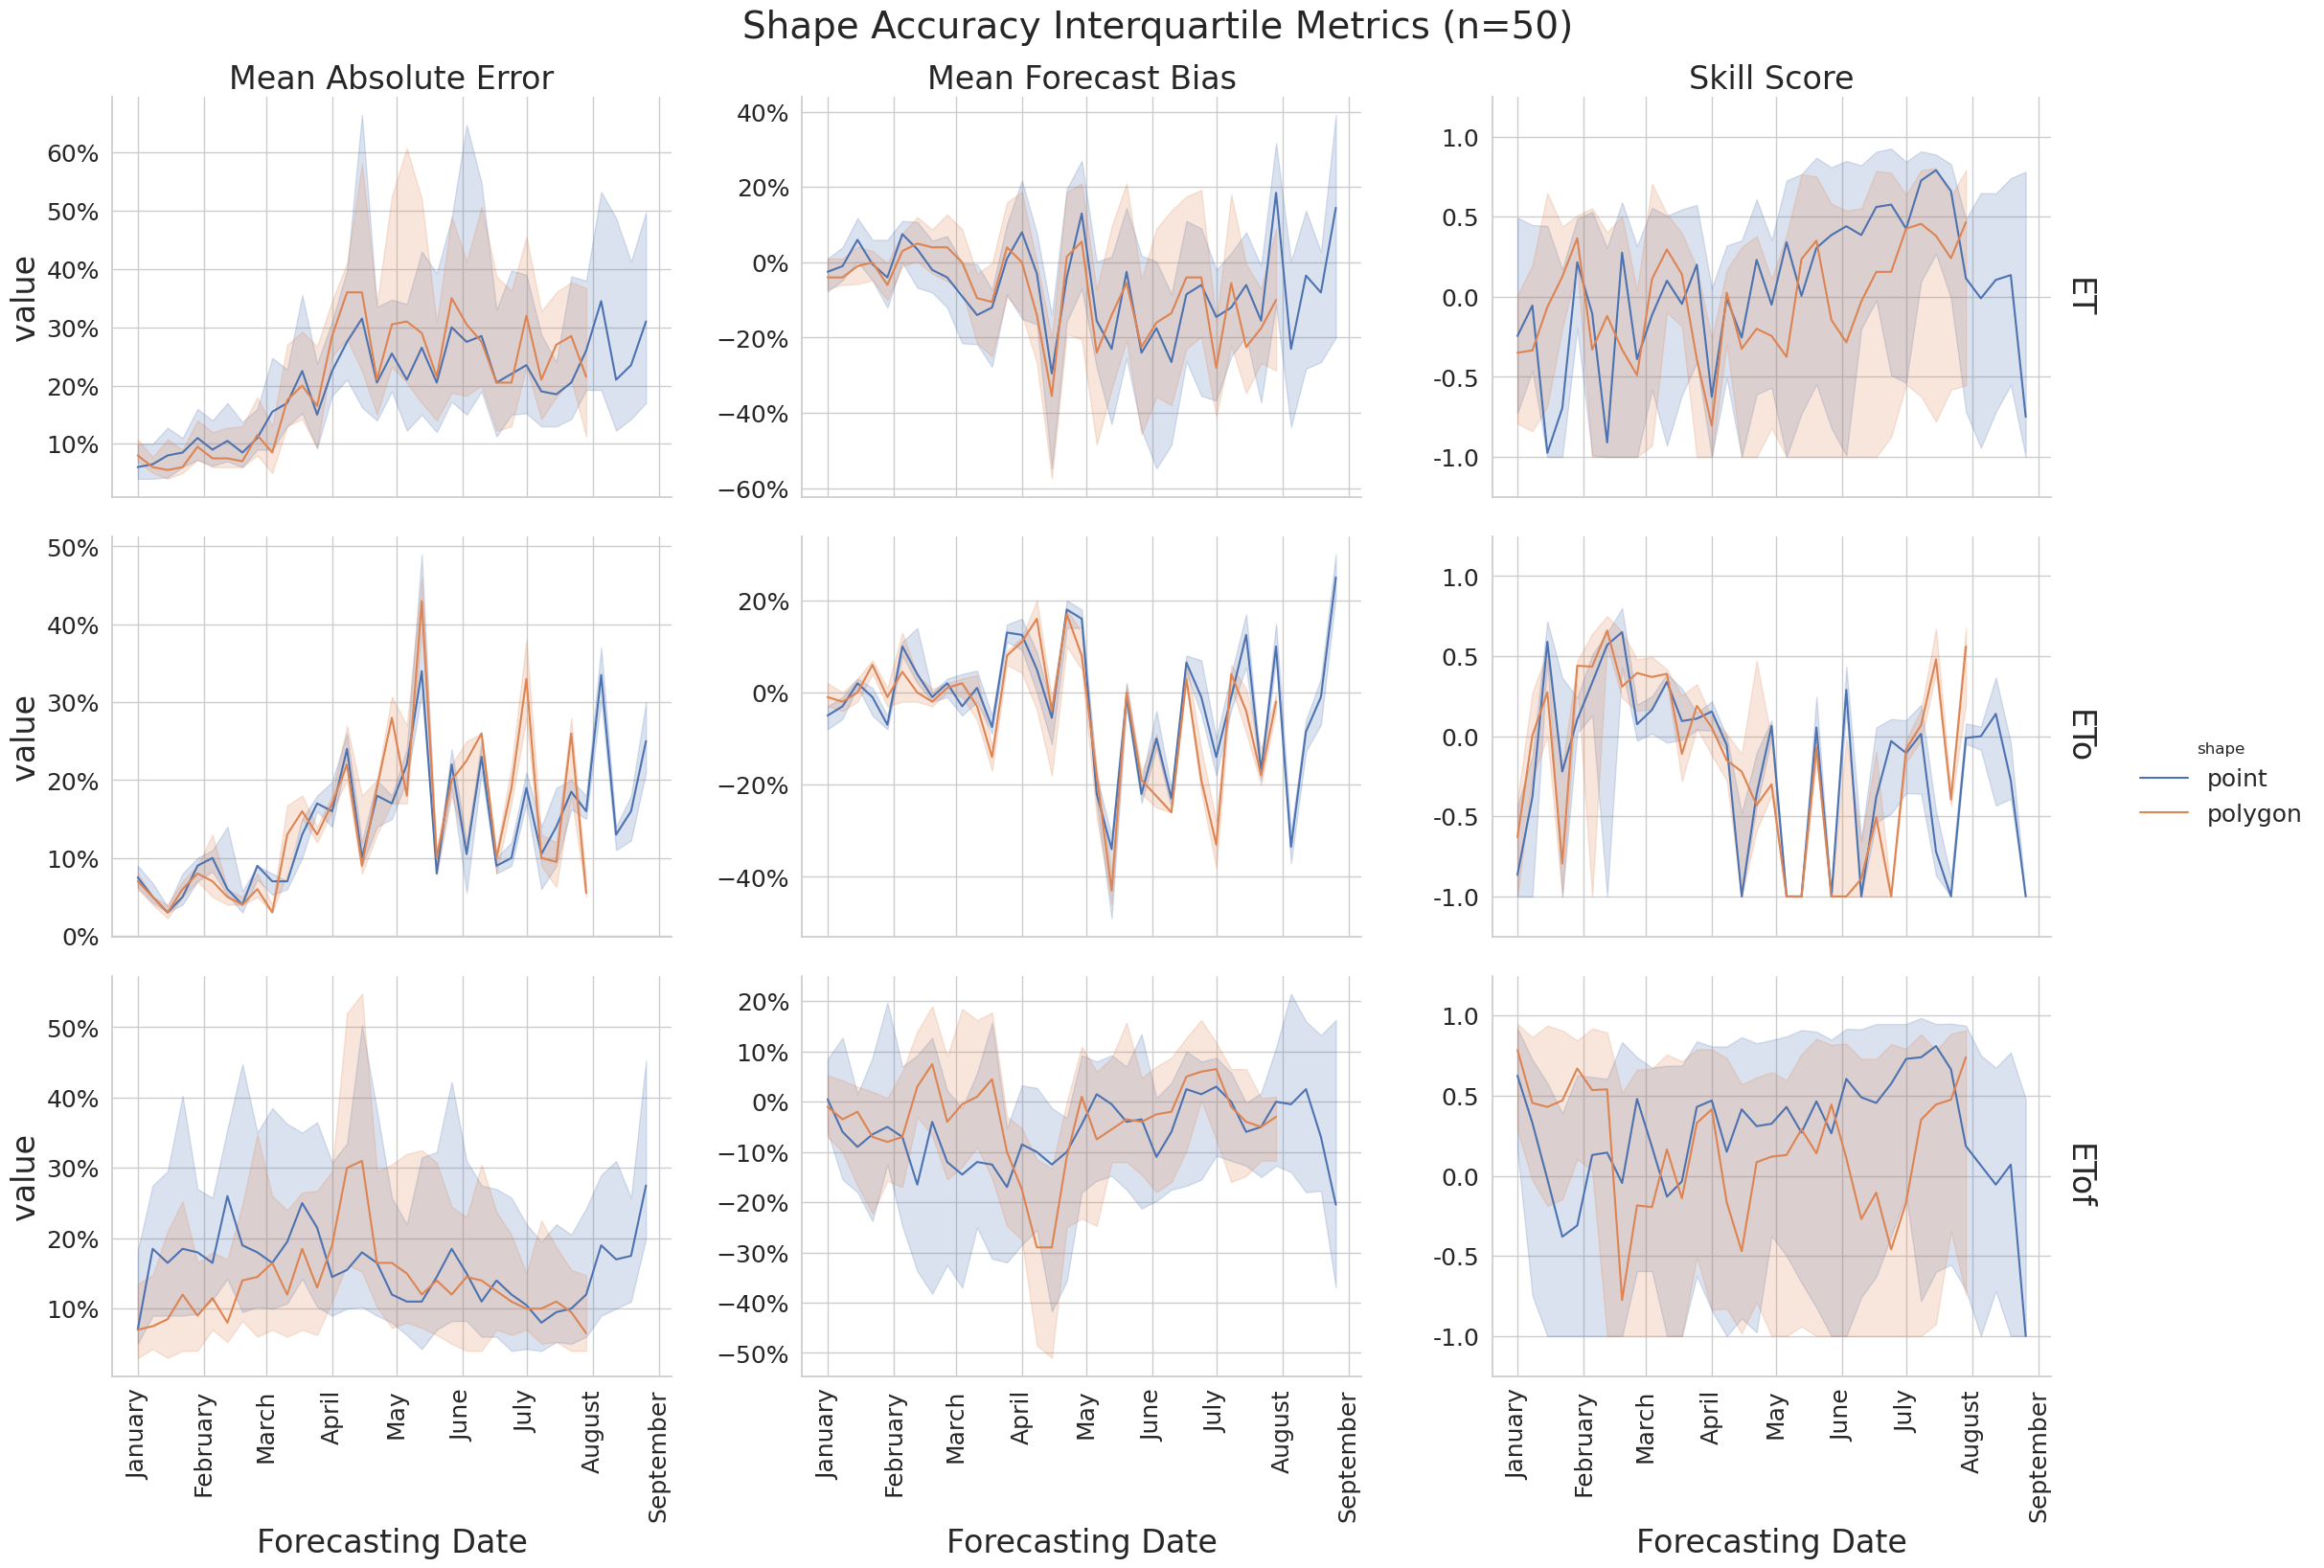

In [27]:
rel = timeseries_rel(shape_metrics_long, row='variable', col='name', y='value', hue='shape',
                     errorbar=("pi", 50), estimator=np.median, as_percent=True,
                     # refline={'y': 0},
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Shape Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/shape_comparison.png')

# Crop Comparison

In [28]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [69, 72, 75]

In [29]:
shape_crop_plotter = shape_metrics_long[shape_metrics_long['crop'].isin(crop_selector)]
shape_crop_plotter.head()

,forecasting_date,field_id,crop,variable,stat,value,name,shape,Class_Names,ESRI_Red,ESRI_Green,ESRI_Blue,Erdas_Red,Erdas_Green,Erdas_Blue
24,2024-01-01,CA_298397,75,ETof,mae,0.13,Mean Absolute Error,point,Almonds,0,168,132,0.0,0.6471,0.5098
75,2024-01-01,CA_299395,75,ETof,mae,0.70,Mean Absolute Error,point,Almonds,0,168,132,0.0,0.6471,0.5098
78,2024-01-01,CA_299467,75,ETof,mae,0.01,Mean Absolute Error,point,Almonds,0,168,132,0.0,0.6471,0.5098
120,2024-01-01,CA_300271,75,ETof,mae,0.05,Mean Absolute Error,point,Almonds,0,168,132,0.0,0.6471,0.5098
138,2024-01-01,CA_300581,75,ETof,mae,0.23,Mean Absolute Error,point,Almonds,0,168,132,0.0,0.6471,0.5098


In [30]:
shape_crop_plotter[shape_crop_plotter['shape'] == 'point']['crop'].value_counts()

crop
75    3465
69    3150
72    1260
Name: count, dtype: int64

In [31]:
shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')

/tmp/ipykernel_1506573/1161630914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')


/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


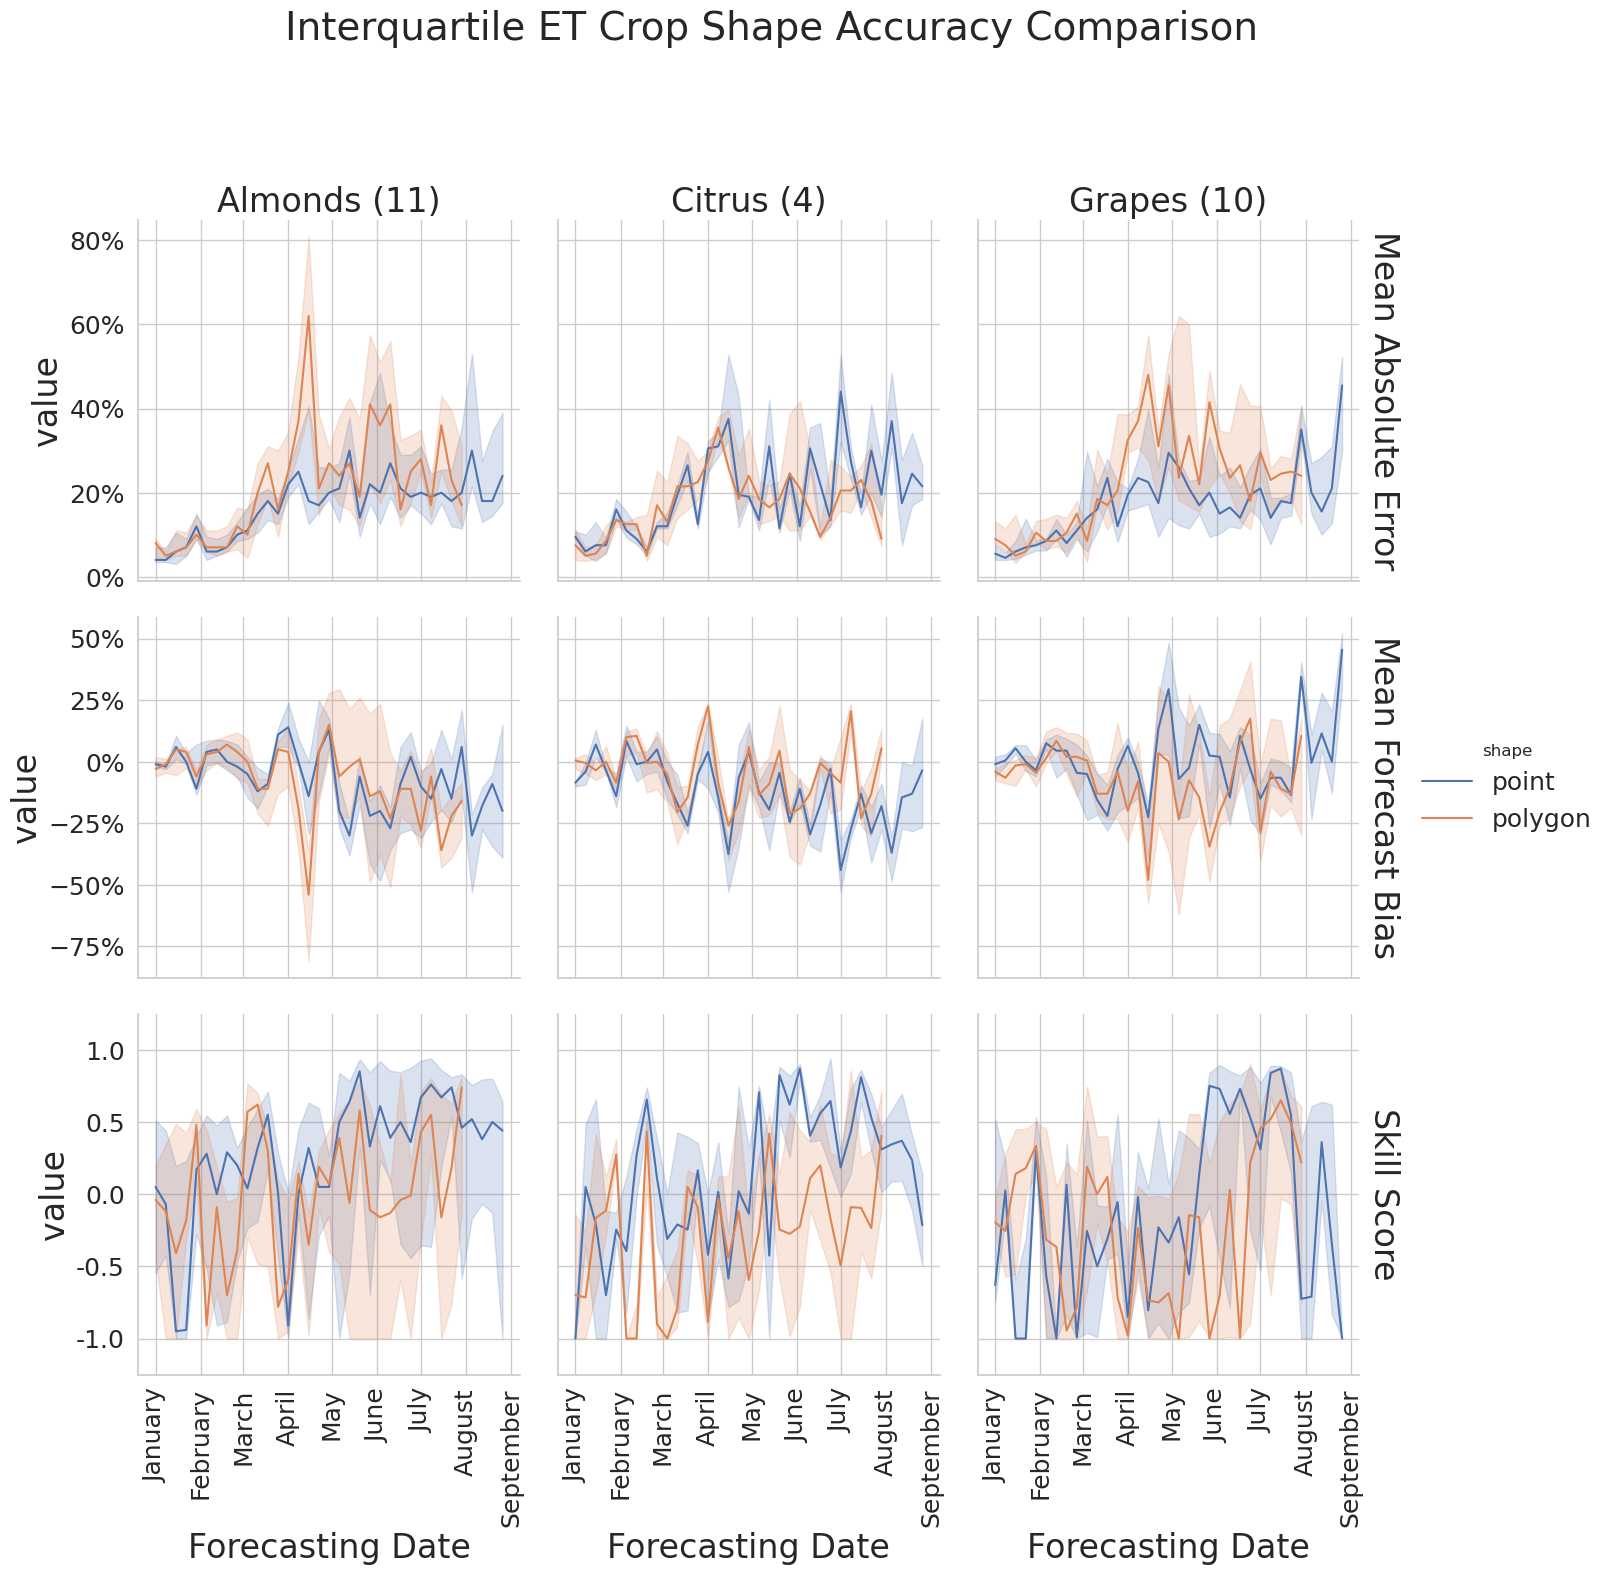

In [32]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ET Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/et_crop_shape_compare.png");

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


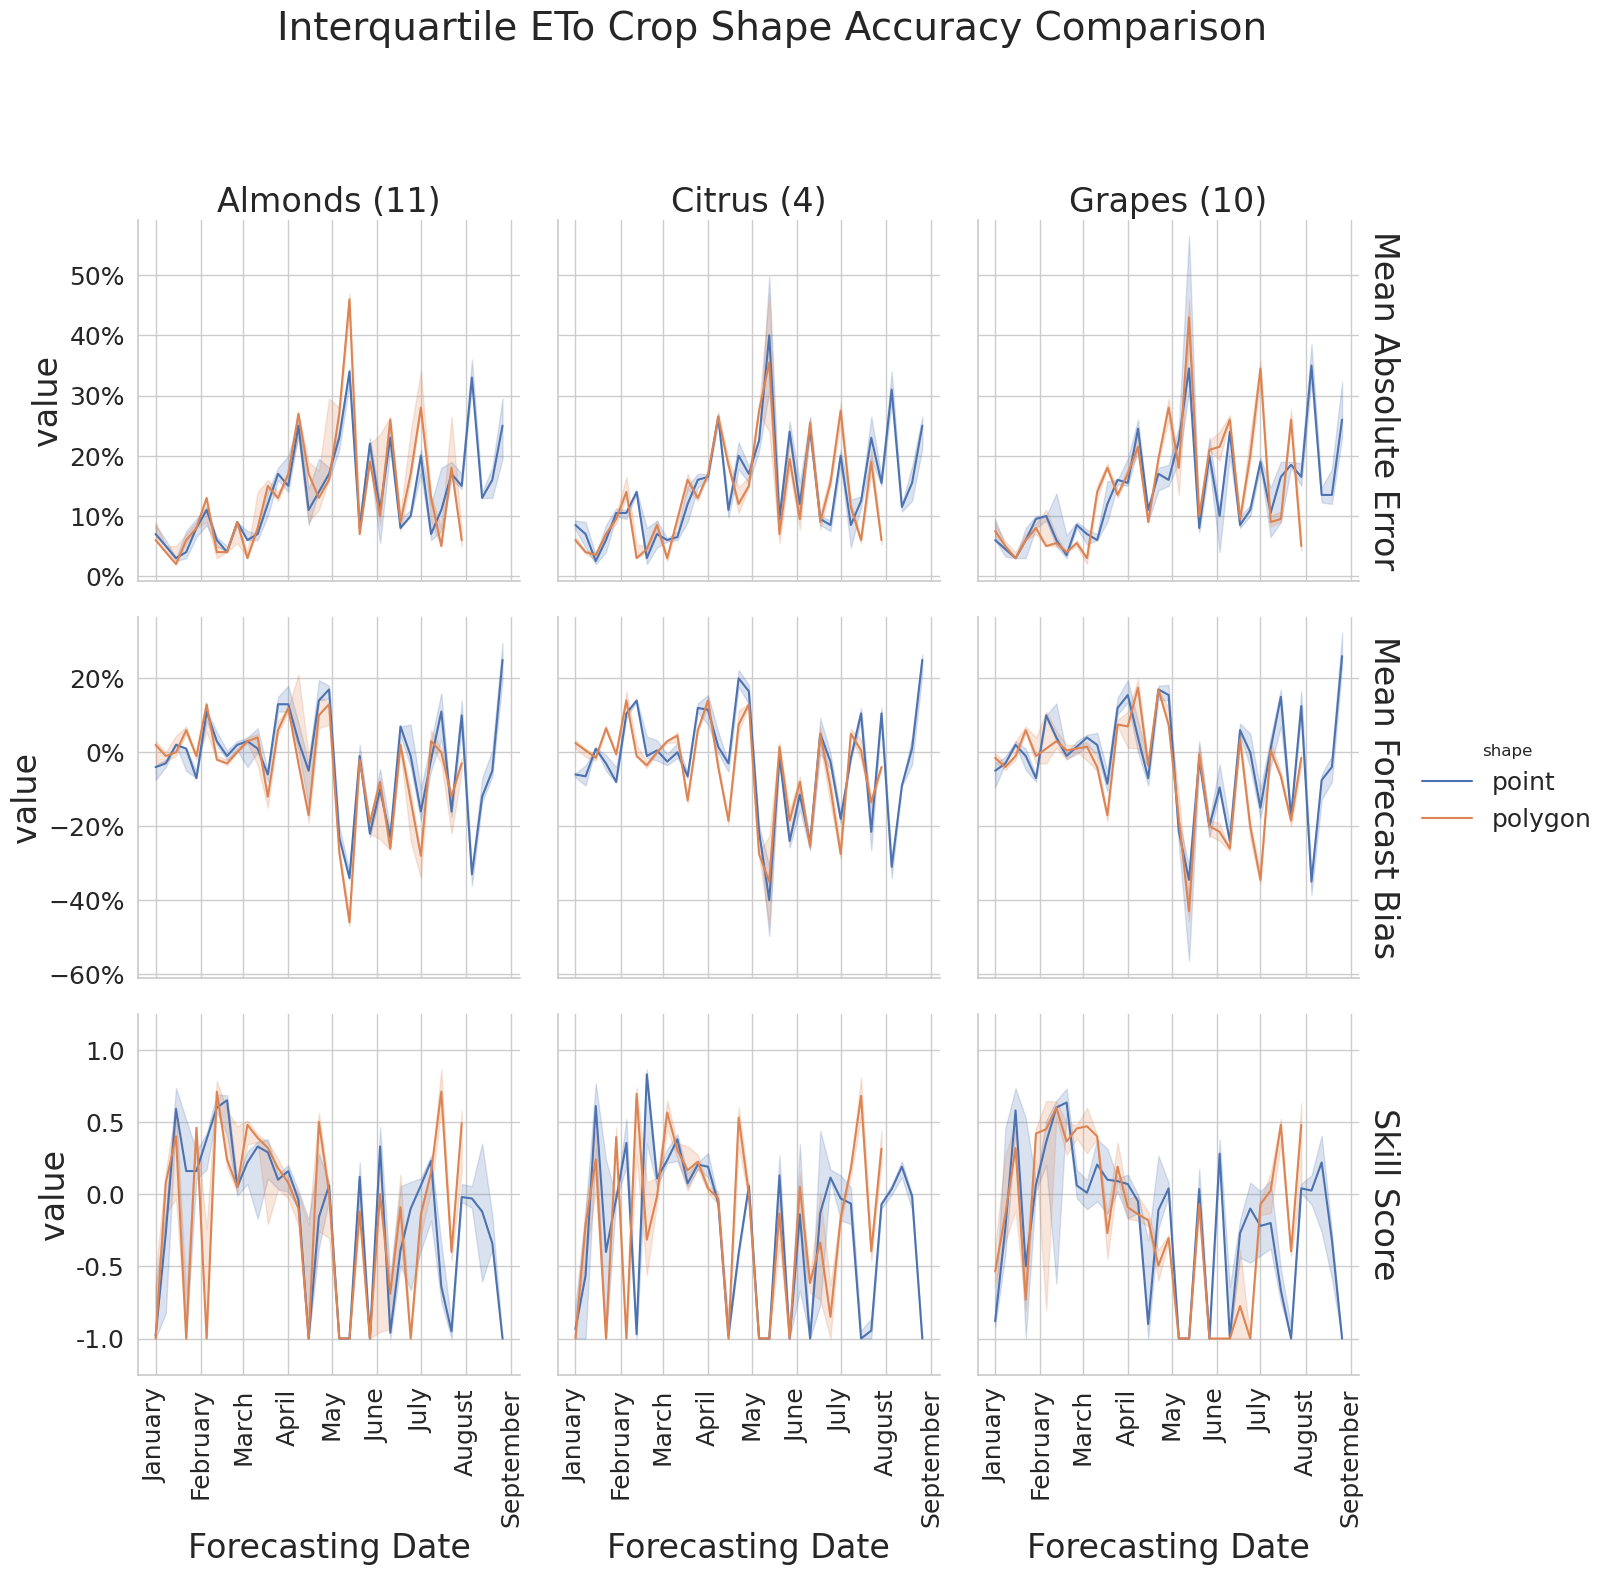

In [33]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETo Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/eto_crop_shape_compare.png")

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


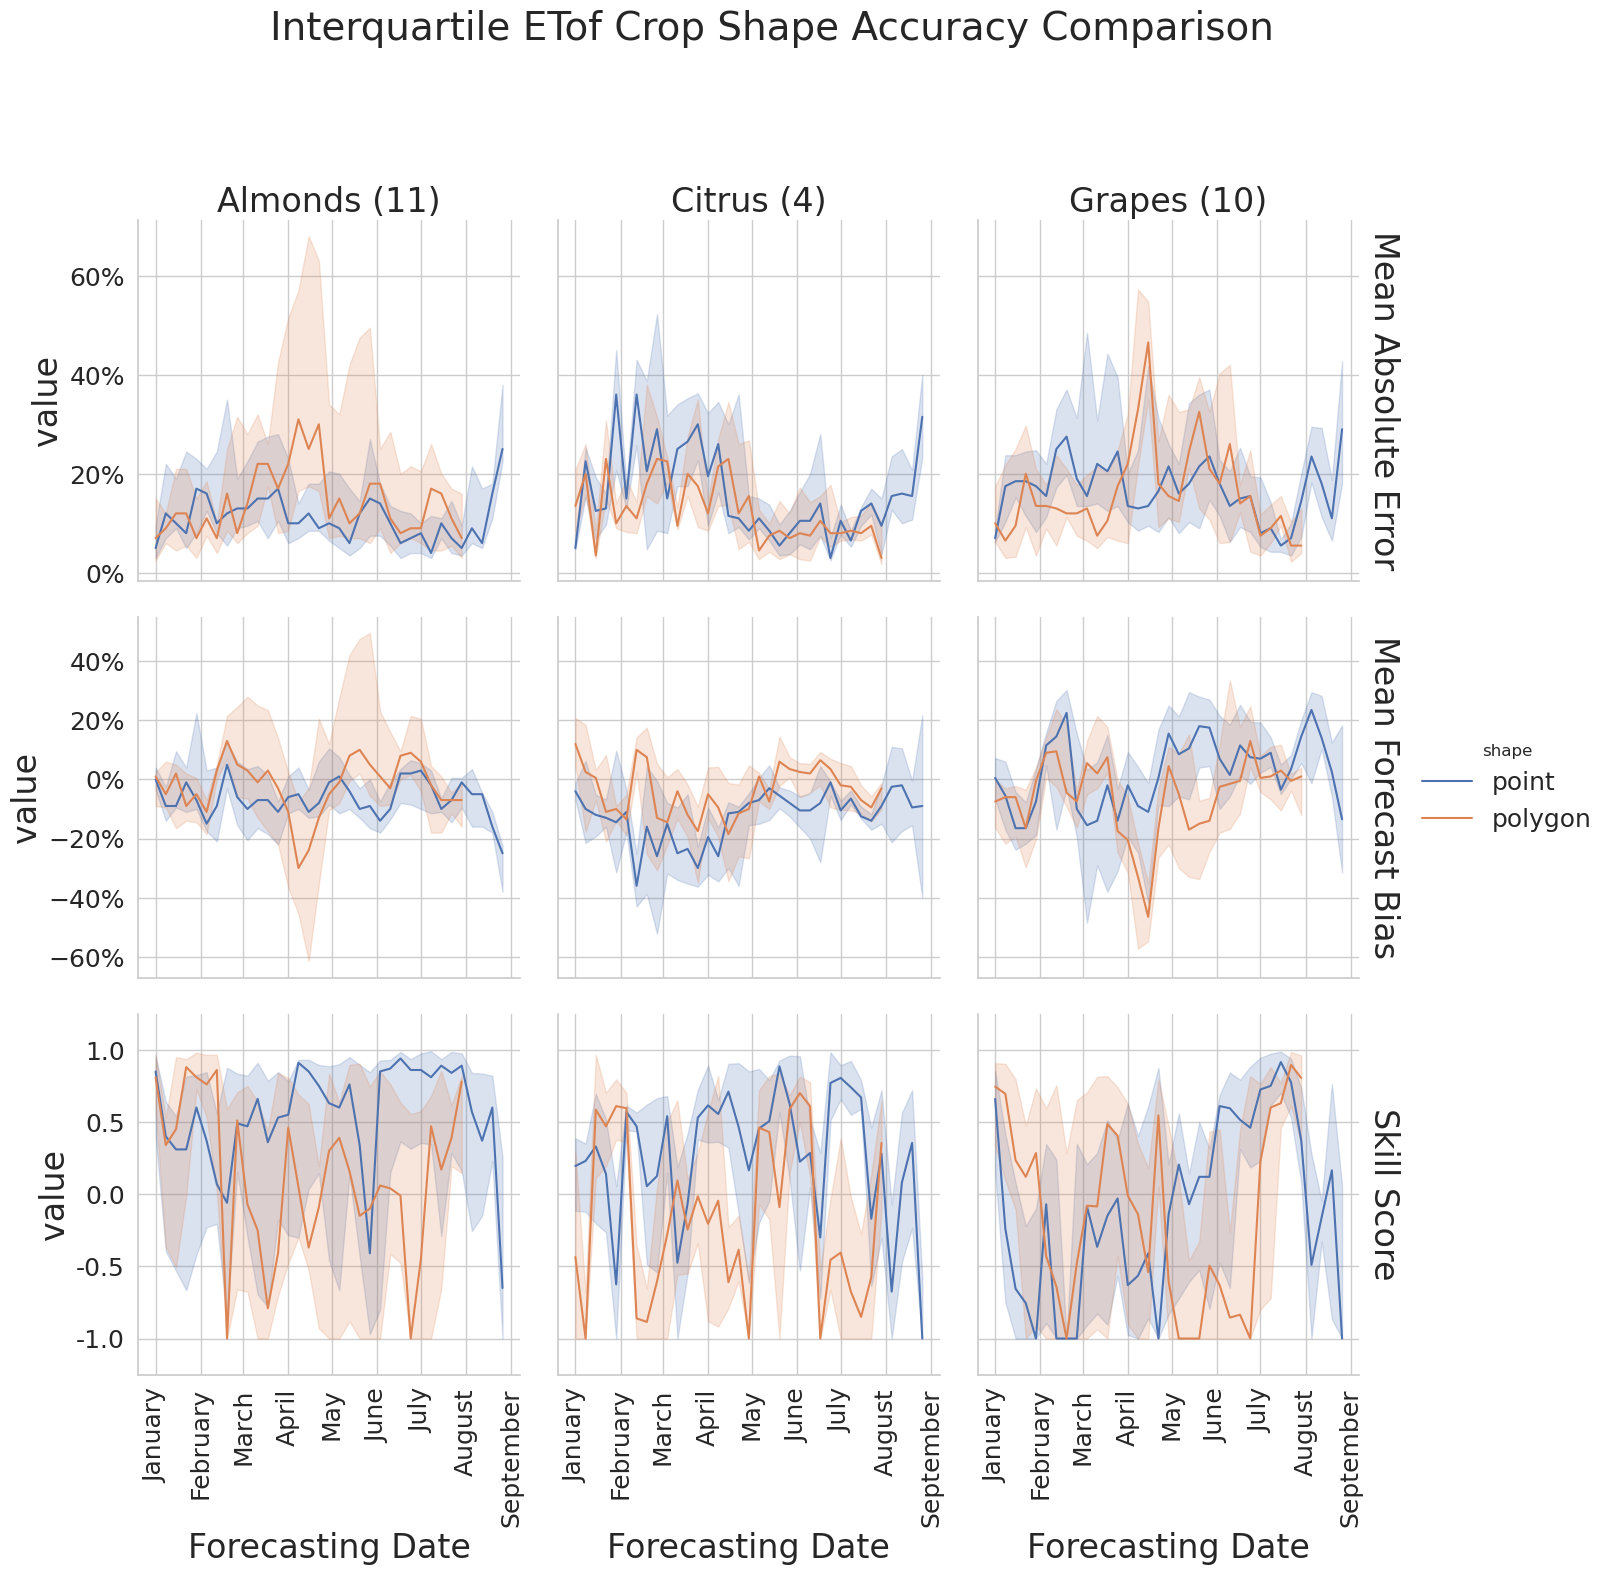

In [34]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETof Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/etof_crop_shape_compare.png")